# Gut–brain axis hierarchical analysis in ASD

This tutorial demonstrates how to apply CauTrigger to a multi-layer dataset representing the gut–brain axis in Autism Spectrum Disorder (ASD). The hierarchical structure consists of gut microbiota (upstream), host proteome,
and ASD-related neurodevelopmental states (downstream).

In this example, we will:
1. identify ASD-associated host proteins;
2. infer microbiota-to-host regulatory effects;
3. perform in silico modulation of key taxa (e.g., *Faecalibacterium*) to examine
   their potential causal influence on ASD-related profiles.

Data source：Integrative multi-omics analysis of autism spectrum disorder reveals unique microbial macromolecules interactions.

## Import and environment setup

In [1]:
import os
import re
import math
import warnings
import logging
import sys
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, f_oneway, norm
from sklearn.preprocessing import normalize, minmax_scale, FunctionTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import scanpy as sc
import torch
import torch.nn as nn

warnings.filterwarnings("ignore")
logging.getLogger('matplotlib.font_manager').disabled = True
plt.rcParams.update({
    'pdf.fonttype': 42,
    'font.sans-serif': ['Arial'],
    'font.family': 'sans-serif'
})
torch.cuda.set_device(0)
from cautrigger.utils import set_seed, select_features
from cautrigger.model import CauTrigger1L, CauTrigger2L

## Load and preprocess data

In [2]:
data_dir = os.path.join("..", "data")
output_dir = os.path.join("..", "output")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Load microbiome (16S rRNA) data and normalize
microb_df = pd.read_csv(os.path.join(data_dir, "16sRNA.csv"), index_col=0).fillna(0)  # 125 features × 60 samples
microb_df = microb_df.iloc[np.where((microb_df.T != 0).sum(axis=0) >= 6)[0], :]      # keep ≥6-sample features: 74
microb_df[:] = minmax_scale(microb_df)  # min–max normalization

# Load host proteome data
prot = pd.read_csv(os.path.join(data_dir, "host_Proteomics.csv"), index_col=0)  # 191 features

# Quick summary
print("Microbiome shape:", microb_df.shape)
print("Proteome shape:", prot.shape)

Microbiome shape: (74, 60)
Proteome shape: (192, 60)


In [4]:
# Reorder column names (e.g. '1A' → 'A1')
def reorder_column_name(col):
    match = re.match(r"(\d+)([A-Z])", col)
    if match:
        return match.group(2) + match.group(1)
    else:
        return col

prot.columns = [reorder_column_name(col) for col in prot.columns]

# Sort columns by group letter and number (e.g. A1, A2, B1, B2, …)
def sort_key(col):
    match = re.match(r"([A-Z])(\d+)", col)
    if match:
        return (match.group(1), int(match.group(2)))
    return (col, 0)

# Extract label row and remove it from data
sorted_columns = sorted(prot.columns, key=sort_key)
prot = prot[sorted_columns]
labels = prot.loc['Label']
prot_df = prot.iloc[1:]
# Normalize proteome features
prot = minmax_scale(prot_df)
prot_df.iloc[:] = prot

# Quick summary
print("Proteome matrix shape:", prot_df.shape)
print("Label counts:\n", labels.value_counts())

Proteome matrix shape: (191, 60)
Label counts:
 Label
Autism     30
Control    30
Name: count, dtype: int64


## Train CauTrigger (Microbiota → Proteome → ASD)

In [5]:
set_seed(42)

In [6]:
adata_layer1 = sc.AnnData(X=np.array(prot, dtype=np.float32).T)
adata_layer1.obs_names = prot_df.columns
adata_layer1.var_names = prot_df.index
adata_layer1.obs['labels_ori'] = labels.values
adata_layer1.obs['labels'] = labels.apply(lambda tg: 1 if tg == labels[0] else 0)

model_1L = CauTrigger1L(
    adata_layer1,
    n_latent=10,
    n_hidden=128,
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=True,
    dpd_linear=False,
    init_weight=None,
    init_thresh=0.0,
    attention=False,
    att_mean=False,
)
model_1L.train(max_epochs=300, stage_training=True)
df_layer1, _ = model_1L.get_up_feature_weights(method='SHAP', sort_by_weight=False)

training: 100%|███████████████████████████████████████████████████████████████████████| 300/300 [00:21<00:00, 13.85it/s]


In [7]:
topk_indices = df_layer1["weight"].values.argsort()[-100:]
X_down = adata_layer1[:, topk_indices]
microb_df = microb_df.loc[:, prot_df.columns]  # ensure sample order matches proteome
microb = microb_df.to_numpy(dtype=np.float32)

adata_layer2 = sc.AnnData(
    X=microb.T,
    obsm={"X_down": X_down.X.toarray()}
)
adata_layer2.obs_names = microb_df.columns
adata_layer2.var_names = microb_df.index
adata_layer2.obs['labels_ori'] = labels.values
adata_layer2.obs['labels'] = labels.apply(lambda tg: 1 if tg == labels[0] else 0)

model_2L = CauTrigger2L(
    adata_layer2,
    n_latent=10,
    n_hidden=128,
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=True,
    dpd_linear=True,
    init_weight=None,
    init_thresh=0.0,
    attention=False,
    att_mean=False,
)
model_2L.train(max_epochs=300, stage_training=True)
df_layer2, _ = model_2L.get_up_feature_weights(method='SHAP', sort_by_weight=True)
# Simple summary
print(f"Layer 2 training completed — {adata_layer2.shape[1]} microbial features evaluated.")
print("Top 10 microbial contributors:")
print(df_layer2.head(10))

training: 100%|███████████████████████████████████████████████████████████████████████| 300/300 [00:23<00:00, 13.03it/s]


Layer 2 training completed — 74 microbial features evaluated.
Top 10 microbial contributors:
                    weight  weight_signed
Series                                   
Faecalibacterium  0.278990       0.342691
Blautia           0.124558      -0.010968
Akkermansia       0.105099      -0.223109
Subdoligranulum   0.067755       0.024388
Agathobacter      0.067664       0.038170
Bacteroides       0.048413       0.083139
Anaerostipes      0.043777      -0.014271
Roseburia         0.031823      -0.029663
Catenibacterium   0.026563       0.051050
Streptococcus     0.023892       0.026607


## Information flow and downstream analyses

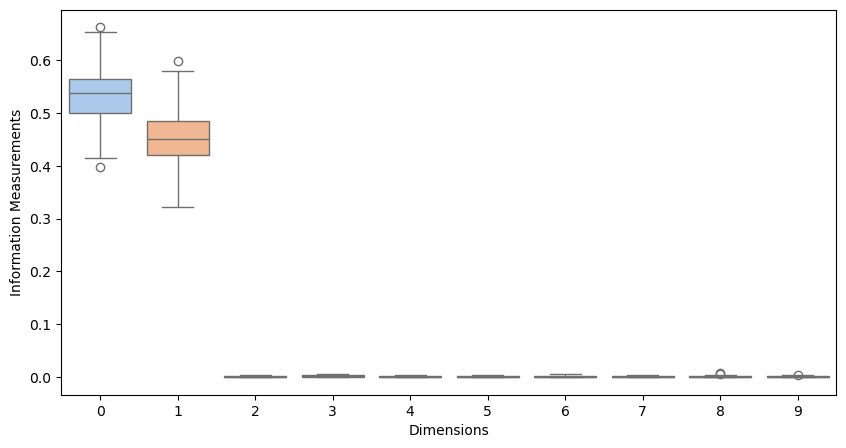

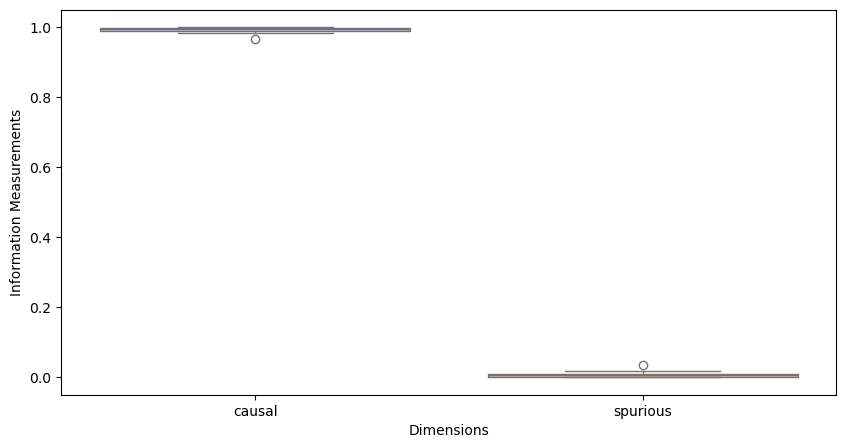

(            0         1             2             3         4             5  \
 A1   0.562598  0.418144  3.526212e-03  3.808624e-03  0.001301  1.286136e-03   
 A2   0.611618  0.362133  4.217830e-03  4.015763e-03  0.003362  3.016877e-03   
 A3   0.661944  0.322586  3.082322e-03  1.764562e-03  0.001147  1.458144e-03   
 A4   0.507625  0.471114  3.447402e-03  3.799835e-03  0.001759  2.355881e-03   
 A5   0.451875  0.537122  1.369952e-03  1.326702e-03  0.000968  1.698462e-03   
 A6   0.549691  0.447380  5.806745e-04  8.256617e-04  0.000148  7.485181e-05   
 A7   0.632127  0.363819  5.151923e-04  9.642381e-04  0.000372  2.647664e-04   
 A8   0.562081  0.422858  2.842905e-03  2.313761e-03  0.001767  1.088076e-03   
 A9   0.546428  0.452187  1.584434e-04  3.361196e-04  0.000081  8.134935e-05   
 A10  0.415078  0.578511  1.053464e-03  1.585274e-03  0.000399  3.859340e-04   
 A11  0.583241  0.414499  2.580904e-04  3.602486e-04  0.000165  7.897102e-05   
 A12  0.397485  0.598494  5.651640e-04  

In [8]:
model_1L.compute_information_flow(plot_info_flow=True, skip_single_info = False, save_fig=True, save_dir=output_dir)

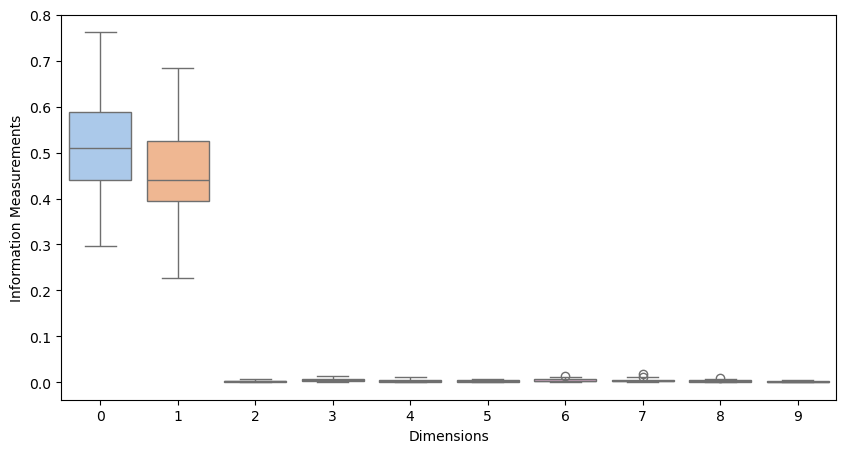

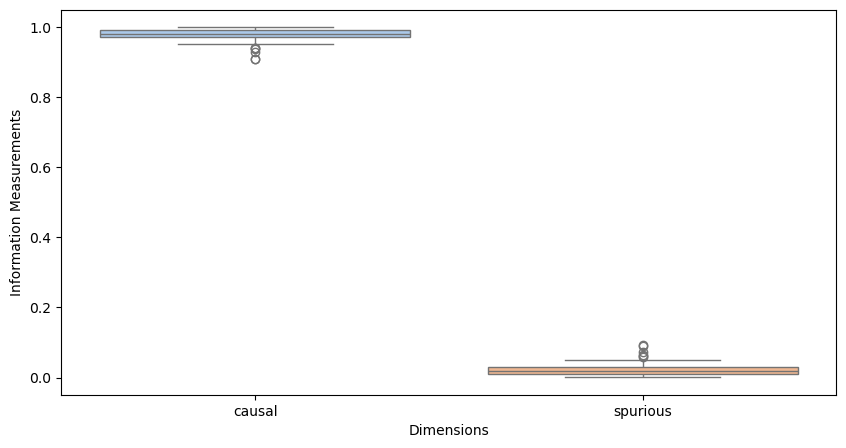

(            0         1         2         3         4         5         6  \
 A1   0.554981  0.415814  0.004138  0.002942  0.004476  0.003486  0.005544   
 A2   0.621547  0.374953  0.000371  0.000501  0.000584  0.000321  0.000407   
 A3   0.652142  0.323874  0.002154  0.004368  0.002797  0.002901  0.003153   
 A4   0.530089  0.414118  0.004388  0.009052  0.007182  0.004820  0.014331   
 A5   0.306868  0.684964  0.000786  0.001935  0.001644  0.000452  0.001312   
 A6   0.651774  0.312302  0.002657  0.004158  0.005117  0.003854  0.007312   
 A7   0.563728  0.405575  0.002349  0.005248  0.003718  0.003114  0.005643   
 A8   0.472373  0.491446  0.003695  0.005826  0.004900  0.004465  0.005637   
 A9   0.453718  0.523984  0.001473  0.002875  0.004293  0.002841  0.003430   
 A10  0.511689  0.438082  0.002309  0.013257  0.005567  0.003898  0.008064   
 A11  0.478031  0.496172  0.001961  0.005210  0.005158  0.001846  0.002444   
 A12  0.562301  0.414804  0.001784  0.004483  0.003117  0.002188

In [9]:
model_2L.compute_information_flow(plot_info_flow=True, save_fig=True, skip_single_info = False, save_dir=output_dir)

In [10]:
adata_protein = sc.AnnData(X=microb.T)
adata_protein.var_names = microb_df.index
adata_protein.obs['labels_ori'] = labels.values
adata_protein.obs['labels'] = labels.apply(lambda tg: 1 if tg == labels[0] else 0)
adata_protein.obsm['X_ct_1'] = model_1L.get_model_output()['latent'][:,:2]
adata_protein.obsm['X_ct_2'] = model_2L.get_model_output()['latent'][:,:2]
print("Layer 1 latent shape:", adata_protein.obsm['X_ct_1'].shape)
print("Layer 2 latent shape:", adata_protein.obsm['X_ct_2'].shape)

Layer 1 latent shape: (60, 2)
Layer 2 latent shape: (60, 2)


UMAP computed and saved successfully.
Saved to: ../output/umap.pdf


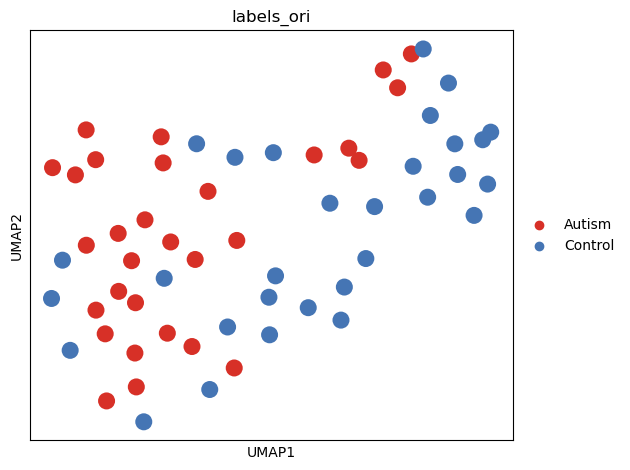

In [11]:
sc.pp.neighbors(adata_protein)
sc.tl.umap(adata_protein)
sc.pl.umap(adata_protein, color='labels_ori', palette={"Autism": "#D73027", "Control": "#4575B4"}, show=False, size=600)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'umap.pdf'))
print("UMAP computed and saved successfully.")
print(f"Saved to: {os.path.join(output_dir, 'umap.pdf')}")

## Calculate causal/non-causal features contribution to PC loadings

In [12]:
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu


# X: shape (n_samples, n_genes)
pca = PCA(n_components=20)
pca.fit(adata_layer2.X)

loadings = pca.components_.T  # shape: (n_genes, 2)

df = pd.DataFrame(loadings[:, :2], columns=['PC1', 'PC2'], index=adata_layer2.var_names)

df['PC1_abs'] = np.abs(df['PC1'])
df['PC2_abs'] = np.abs(df['PC2'])

top_PC1 = df.sort_values('PC1_abs', ascending=False).head(10)
top_PC2 = df.sort_values('PC2_abs', ascending=False).head(10)
adata_layer2pca = pca.transform(adata_layer2.X)

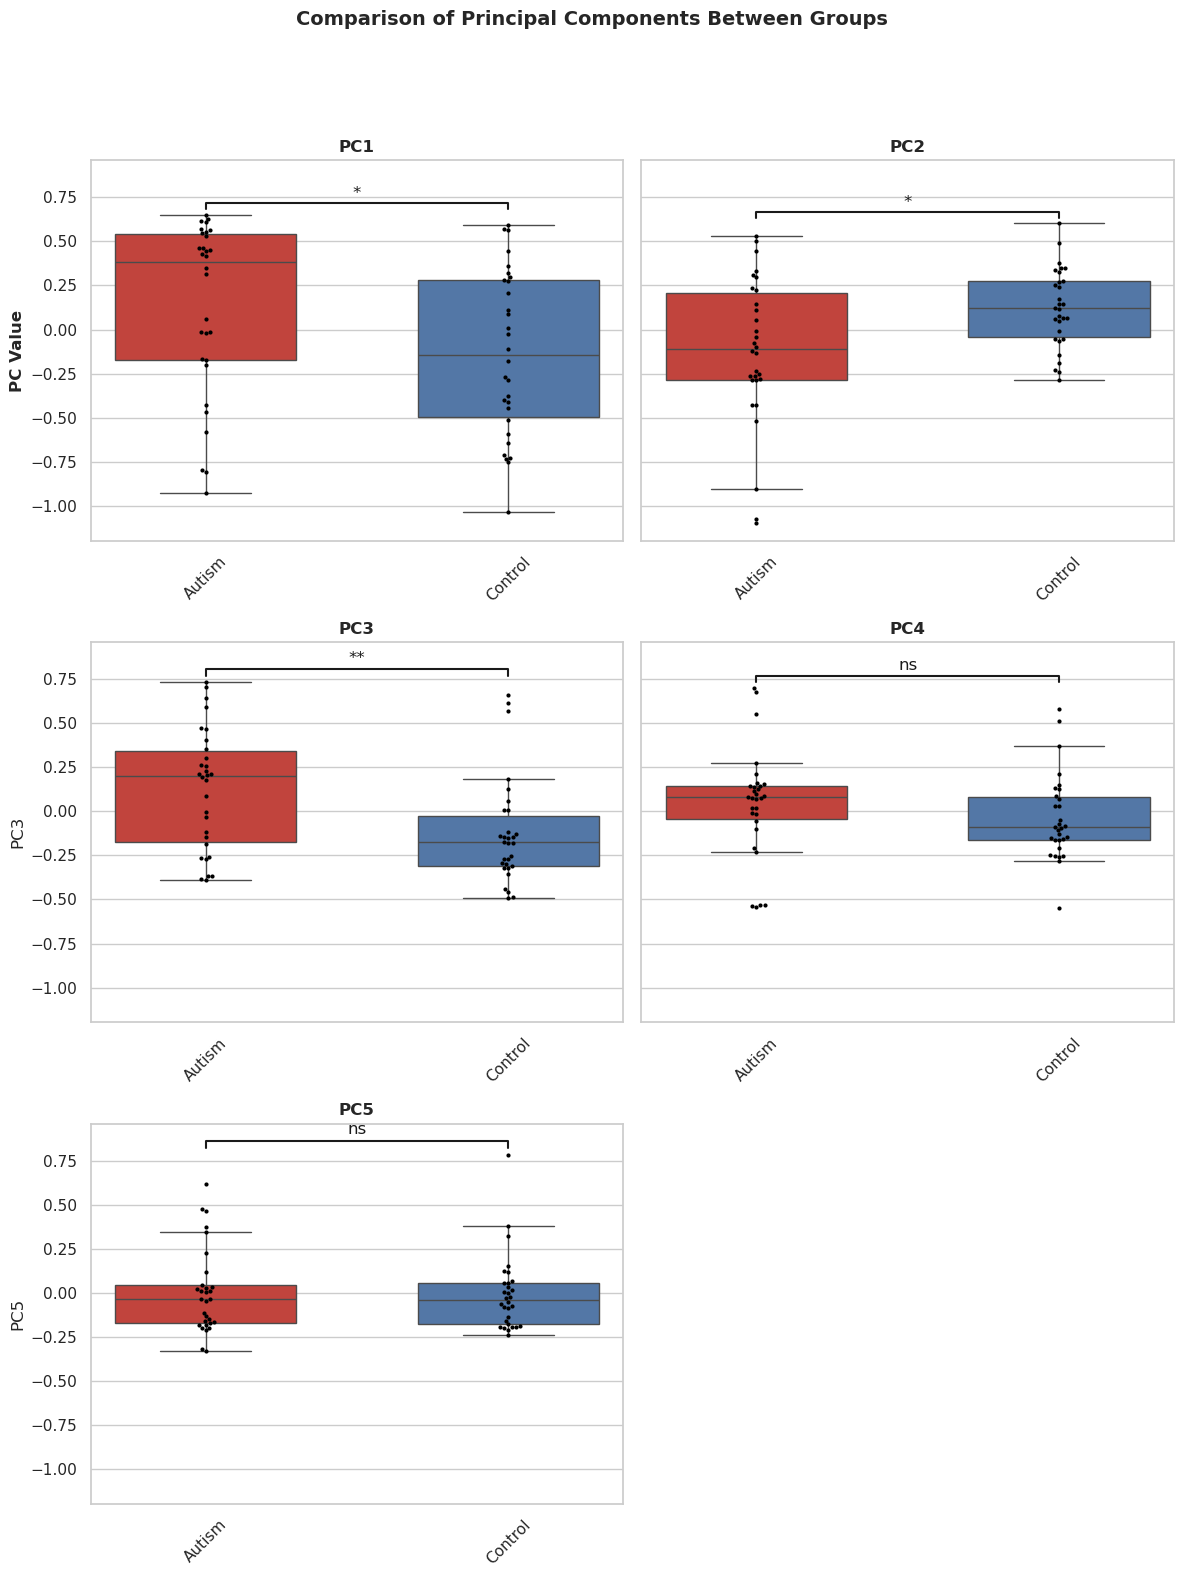

In [13]:
# Visualize and test group differences (ASD vs Control) across top 5 PCA components.
# This confirms that ASD samples are separable from controls in major microbiome variance directions.

sns.set(style="whitegrid", palette="pastel")

k = 5  # number of PCs to compare
df = pd.DataFrame(adata_layer2pca[:, :k], columns=[f'PC{i+1}' for i in range(k)])
df['Group'] = adata_layer2.obs['labels_ori'].values

n_cols = 2
n_rows = int(np.ceil(k / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), sharey=True)
axes = axes.flatten()

palette = {"Autism": "#D73027", "Control": "#4575B4"}
for i, ax in enumerate(axes):
    if i >= k:
        ax.axis('off')
        continue
    pc_name = f'PC{i+1}'
    sns.boxplot(
        x='Group', 
        y=pc_name, 
        data=df, 
        ax=ax,
        palette=palette,
        width=0.6,
        showfliers=False
    )
    sns.swarmplot(
        x='Group',
        y=pc_name,
        data=df,
        ax=ax,
        color='black',
        alpha=1,
        size=3
    )
    
    group1 = df[df['Group'] == df['Group'].unique()[0]][pc_name]
    group2 = df[df['Group'] == df['Group'].unique()[1]][pc_name]
    _, p_value = mannwhitneyu(group1, group2)
    
    y_max = df[pc_name].max()
    h = y_max * 0.05
    ax.plot([0, 0, 1, 1], [y_max+h, y_max+2*h, y_max+2*h, y_max+h], lw=1.5, c='k')
    
    if p_value < 0.001:
        symbol = '***'
    elif p_value < 0.01:
        symbol = '**'
    elif p_value < 0.05:
        symbol = '*'
    else:
        symbol = 'ns'
    
    ax.text(0.5, y_max+2.5*h, symbol, ha='center', va='bottom', color='k')
    ax.set_title(pc_name, fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)

axes[0].set_ylabel('PC Value', fontweight='bold')

plt.suptitle('Comparison of Principal Components Between Groups', y=1.05, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'compare_PC1-5.pdf'))
plt.show()

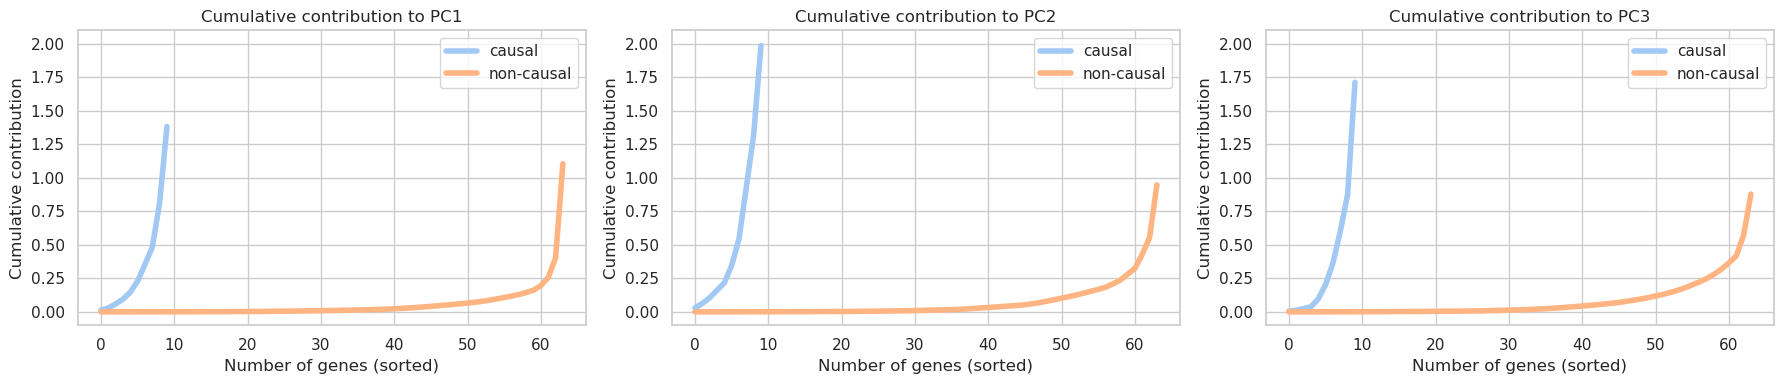

In [14]:
# "causal" taxa = top-ranked microbiota selected by CauTrigger (df_layer2.head(10)).
# "non-causal" = all remaining taxa.
# This plot compares their cumulative PCA loadings to show whether
# causal taxa contribute more strongly to major variance directions (PC1–PC3).

def plot_cumulative_contributions(pca, k=2, figsize=(6, 4)):
    loading_dict = {
        f'PC{i+1}_loading': np.abs(pca.components_[i])
        for i in range(k)
    }
    df = pd.DataFrame({
        'gene': adata_layer2.var_names,
        'group': ['causal' if g in df_layer2.head(10).index else 'non-causal' for g in adata_layer2.var_names],
        **loading_dict
    })

    fig, axes = plt.subplots(1, k, figsize=(figsize[0]*k, figsize[1]))

    if k == 1:
        axes = [axes]
    for i in range(k):
        pc_col = f'PC{i+1}_loading'
        curves = {}

        for group in df['group'].unique():
            subset = df[df['group'] == group].copy()
            sorted_vals = np.sort(subset[pc_col].values)
            cum = np.cumsum(sorted_vals)
            curves[group] = cum

        ax = axes[i]
        for group, cum in curves.items():
            x = np.arange(len(cum))
            ax.plot(x, cum, label=group, linewidth=4)

        ax.set_title(f"Cumulative contribution to PC{i+1}")
        ax.set_xlabel("Number of genes (sorted)")
        ax.set_ylabel("Cumulative contribution")
        ax.set_ylim(-0.1, 2.1)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(output_dir + 'cum_PC.pdf')
    plt.show()

plot_cumulative_contributions(pca, k=3)

## Differential abundance analysis of microbiota

In [15]:
# Prepare microbiome matrix for group-wise comparison
df = pd.DataFrame(microb.T, 
                  columns=microb_df.index, 
                  index=microb_df.columns).astype(float)

# group index from labels
df_index_groups = adata_layer2.obs['labels_ori'].values

In [16]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Differential abundance test using Mann–Whitney U test
pvals = []
log2fcs = []

for col in df.columns:
    a = df[df_index_groups == 'Autism'][col]
    c = df[df_index_groups == 'Control'][col]

    stat, p = mannwhitneyu(a, c, alternative='two-sided')
    pvals.append(p)

    mean_a = np.mean(a)
    mean_c = np.mean(c)
    log2fc = np.log2((mean_a + 1e-8) / (mean_c + 1e-8))
    log2fcs.append(log2fc)

adj_pvals = multipletests(pvals, method='fdr_bh')[1]

deg = pd.DataFrame({
    'feature': df.columns,
    'log2FC': log2fcs,
    'pval': pvals,
    'adj_pval': adj_pvals
})
deg['is_trigger'] = [1 if i in df_layer2.head(10).index else 0 for i in deg.feature]

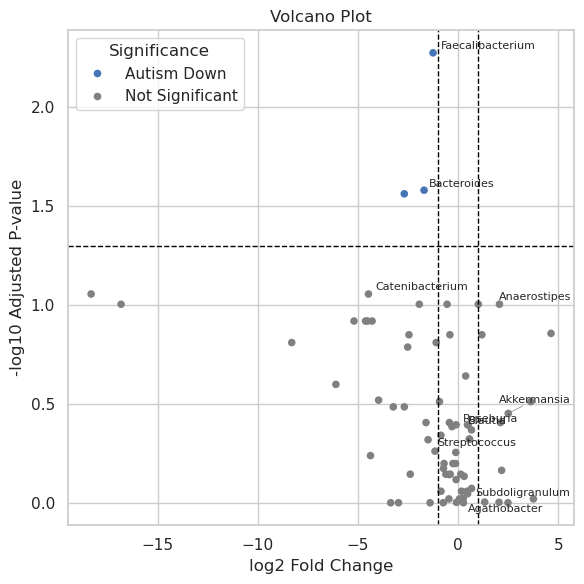

In [17]:
# Volcano plot of differential abundance
pval_thresh = 0.05
log2fc_thresh = 1

deg['significance'] = 'Not Significant'
deg.loc[(deg['adj_pval'] < pval_thresh) & (deg['log2FC'] > log2fc_thresh), 'significance'] = 'Autism Up'
deg.loc[(deg['adj_pval'] < pval_thresh) & (deg['log2FC'] < -log2fc_thresh), 'significance'] = 'Autism Down'

plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=deg,
    x='log2FC',
    y=-np.log10(deg['adj_pval']),
    hue='significance',
    palette={'Autism Up': '#d73027', 'Autism Down': '#4575b4', 'Not Significant': 'gray'},
    s=30,
    edgecolor='none'
)

from adjustText import adjust_text

top_genes = deg.loc[deg.is_trigger == 1,:]
texts = []
for i, row in top_genes.iterrows():
    texts.append(
        plt.text(row['log2FC'], -np.log10(row['adj_pval']), row['feature'], fontsize=8)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    
plt.axhline(-np.log10(pval_thresh), color='black', linestyle='--', linewidth=1)
plt.axvline(log2fc_thresh, color='black', linestyle='--', linewidth=1)
plt.axvline(-log2fc_thresh, color='black', linestyle='--', linewidth=1)

plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 Adjusted P-value')
plt.title('Volcano Plot')
plt.legend(title='Significance', loc='best')
plt.tight_layout()

plt.savefig(os.path.join(output_dir, "volcano_plot.pdf"))
plt.show()

In [18]:
deg.loc[deg.significance == 'Autism Down', :]

,feature,log2FC,pval,adj_pval,is_trigger,significance
0,Bacteroides,-1.705165,0.000709,0.026230,1,Autism Down
13,Escherichia,-2.692314,0.001109,0.027357,0,Autism Down
59,Faecalibacterium,-1.257797,0.000072,0.005295,1,Autism Down


## Significance testing for candidate triggers (permutation)

In [19]:
# Compute SHAP-based permutation significance for microbial triggers
df_shap_global, _ = model_2L.get_up_significance(
    method="SHAP",
    test_mode="permutation",
    perm_mode="global",
    n_perm=100,
    n_bg_samples=60,
    use_signed=True,
    fdr_correct=False,
    show_progress=True,
    random_state=0,
)

# Extract significance results for top microbial triggers
top10 = df_layer2.head(10).index
df_shap_top10 = df_shap_global.loc[top10]

print("Top 10 microbial triggers — SHAP permutation significance:\n")
print(df_shap_top10.to_string())

Permuting: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]

[Note] SHAP-based significance computed via permutation test (global mode, 100 permutations).
Top 10 microbial triggers — SHAP permutation significance:

                    weight  weight_signed    pvalue
Series                                             
Faecalibacterium  0.231107       0.004830  0.039604
Blautia           0.103180      -0.000155  0.504950
Akkermansia       0.087060      -0.003145  0.504950
Subdoligranulum   0.056126       0.000344  0.118812
Agathobacter      0.056051       0.000538  0.019802
Bacteroides       0.040104       0.001172  0.148515
Anaerostipes      0.036264      -0.000201  0.524752
Roseburia         0.026361      -0.000418  0.158416
Catenibacterium   0.022004       0.000720  0.445545
Streptococcus     0.019792       0.000375  0.148515


In [20]:
# Compute SHAP-based permutation significance (per-feature mode)
df_shap_local, _ = model_2L.get_up_significance(
    method="SHAP",
    test_mode="permutation",
    perm_mode="per_feature",
    n_perm=100,
    n_bg_samples=60,
    use_signed=True,
    fdr_correct=False,
    show_progress=True,
    random_state=0,
)

# Extract results for top microbial triggers
top10 = df_layer2.head(10).index
df_shap_local_top10 = df_shap_local.loc[top10]

print("Top 10 microbial triggers — per-feature SHAP permutation significance:\n")
print(df_shap_local_top10.to_string())

Permuting:   0%|                                                                              | 0/100 [1:58:19<?, ?it/s]

[Note] SHAP-based significance computed via permutation test (per_feature mode, 100 permutations).
Top 10 microbial triggers — per-feature SHAP permutation significance:

                    weight  weight_signed    pvalue
Series                                             
Faecalibacterium  0.231107       0.004830  0.049505
Blautia           0.103180      -0.000155  0.772277
Akkermansia       0.087060      -0.003145  0.346535
Subdoligranulum   0.056126       0.000344  0.079208
Agathobacter      0.056051       0.000538  0.029703
Bacteroides       0.040104       0.001172  0.148515
Anaerostipes      0.036264      -0.000201  0.495050
Roseburia         0.026361      -0.000418  0.257426
Catenibacterium   0.022004       0.000720  0.386139
Streptococcus     0.019792       0.000375  0.148515


## In-silico perturbation of significant triggers

In [21]:
# === In-silico perturbation: setup ===
from cautrigger.utils import pert_plot_vector_field, pert_plot_stream

# prepare data
adata_TF = adata_layer2.copy()     # microbiota layer
adata_down = X_down.copy()         # selected proteins
adata_down.obsm['X_umap'] = adata_protein.obsm['X_umap']   # UMAP for visualization


training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


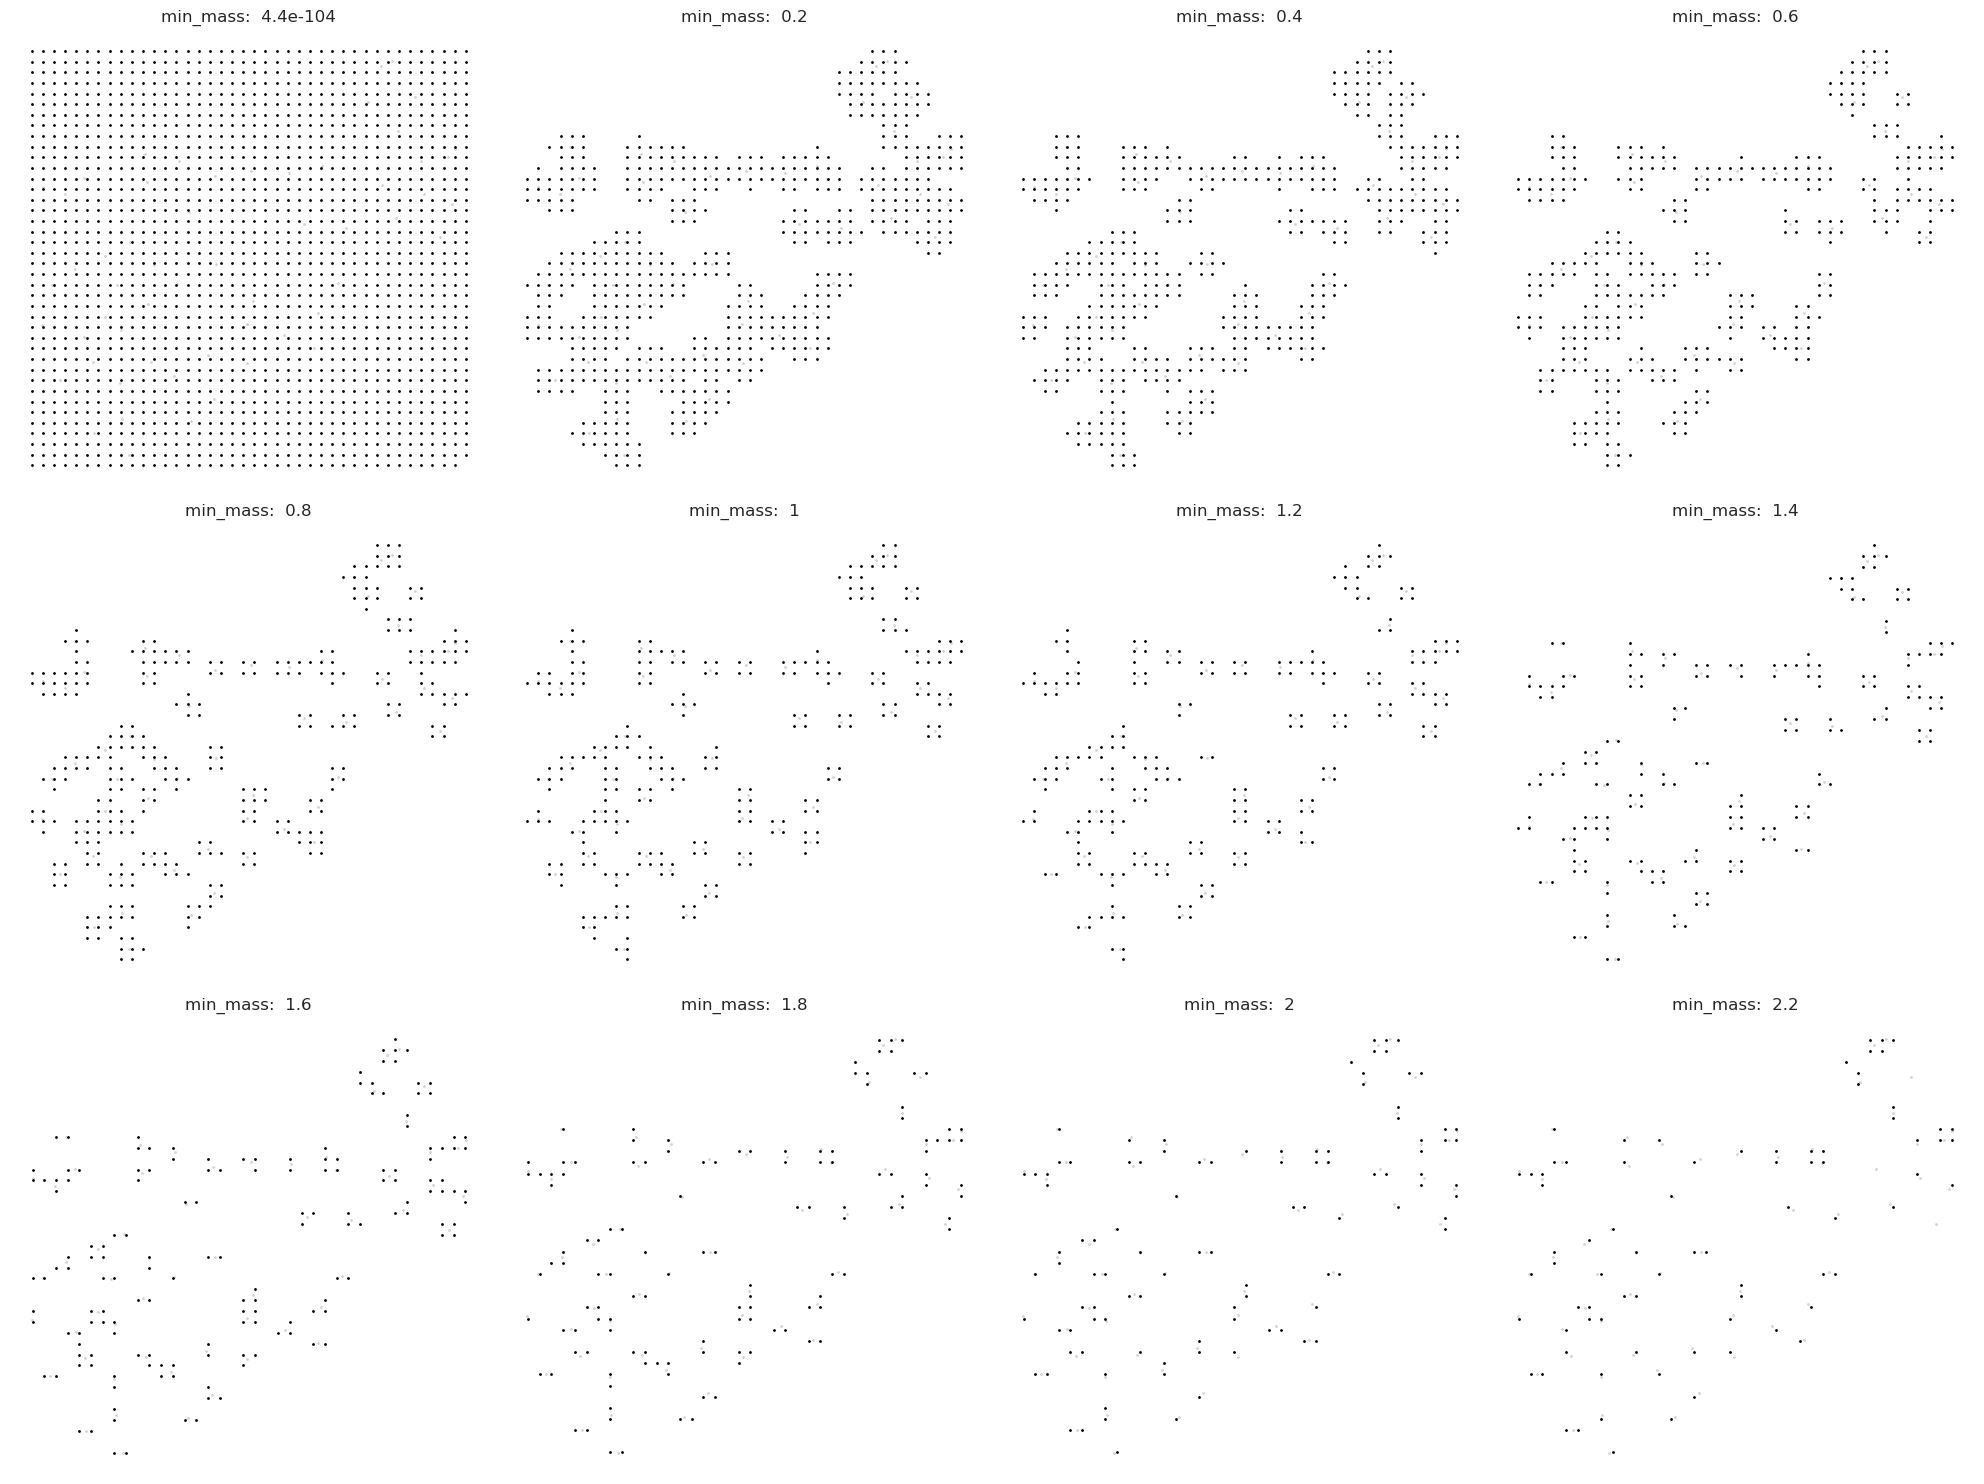

In [ ]:
# === Vector-field perturbation ===
dot_size = 800
pert_Gene = ['Faecalibacterium', 'Roseburia']
fold = [2, 2]

output = pert_plot_stream(
    adata_TF, adata_down, model_2L,
    pert_Gene,
    n_neighbors=None,
    scale=30,
    pert_celltype=['Autism'],     # show ASD only
    run_suggest_mass_thresholds=True,
    fold=fold,
    state_obs='labels_ori',
    dot_size=dot_size,
    min_mass=1.3,
    embedding_name='X_umap'
)


training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


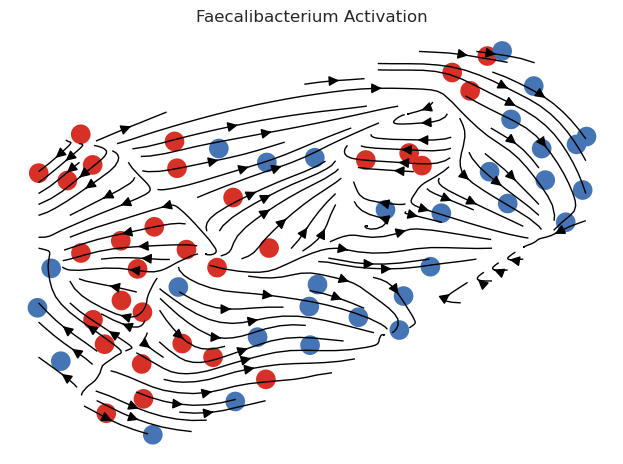

In [28]:
# === Streamline perturbation ===
dot_size = 800
pert_Gene = ['Faecalibacterium']
# pert_Gene = ['Agathobacter']
fold = [5]

model_output_pert1 = pert_plot_stream(
    adata_TF, adata_down, model_2L,
    pert_Gene,
    n_neighbors=None,
    scale=30,
    pert_celltype=['Autism', 'Control'],
    run_suggest_mass_thresholds=False,
    fold=fold,
    state_obs='labels_ori',
    dot_size=dot_size,
    min_mass=1.9,
    embedding_name='X_umap',
    palette={"Autism": "#D73027", "Control": "#4575B4"},
    save_dir=output_dir
)
